In [10]:
import cupy_xarray
import cupy as cp
import xarray as xr
from cupyx.scipy.ndimage import convolve1d


def lanczos_low_pass_weights(window, cutoff):
    """
    Calculate weights for a low pass Lanczos filter.
    Inputs:
    ================
    window: int
        The length of the filter window (odd number).
    cutoff: float
        The cutoff frequency(1/cut off time steps)
    """
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = cp.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = cp.arange(1., n)
    sigma = cp.sin(cp.pi * k / n) * n / (cp.pi * k)
#     sigma = 1.   # edit for testing to match with Charlotte ncl code
    firstfactor = cp.sin(2. * cp.pi * cutoff * k) / (cp.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]


def lanczos_filter_matrix(da_var_anom, window, cutoff):

    wt = lanczos_low_pass_weights(window, cutoff)
    # wt = cp.asarray(wt)

    var_anom_filtered = convolve1d(
        da_var_anom.astype('float64').data,
        wt,
        axis=0,
        output='float64')
    
    del wt

    da_var_anom_filtered = da_var_anom.copy(data=var_anom_filtered)

    return da_var_anom_filtered


In [13]:
ds = xr.open_dataset('./data/q_ml_1984_rechunked.nc').isel(longitude=slice(0,50),latitude=slice(0,50)).load()
da_q_gpu_load = ds.q.cupy.as_cupy()

In [14]:
##### calculate high frequency
# calculate ano and low pass
window = 96+96+1
cutoff = 1/(8*4)   # 6hourly data (4 times daily) for 8 days
da_q_gpu_load = da_q_gpu_load - da_q_gpu_load.mean(dim='time')
%time da_q_gpu_load_filtered = lanczos_filter_matrix(da_q_gpu_load,window,cutoff)

CPU times: user 2.63 ms, sys: 464 µs, total: 3.1 ms
Wall time: 2.66 ms


In [15]:
da_q_gpu_load_filtered.cupy.is_cupy

True

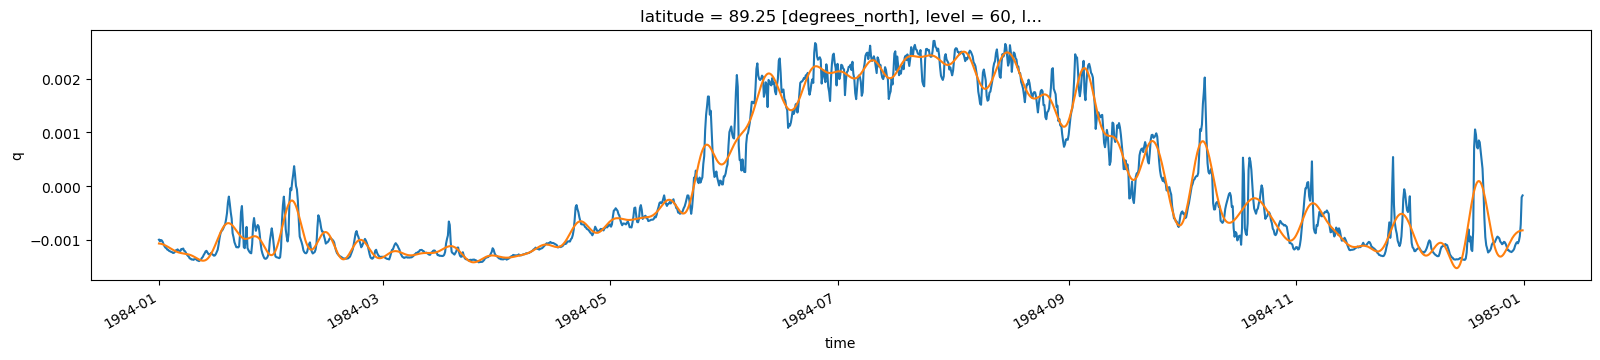

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_axes([0,0,1,0.5])
da_q_gpu_load.isel(longitude=1,latitude=1,level=59).plot(ax=ax1)
da_q_gpu_load_filtered.isel(longitude=1,latitude=1,level=59).plot(ax=ax1)